# EFCamDat 5 Class 2 & 3 step RoBERTa Models

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from transformers import RobertaTokenizer, TFRobertaModel

In [3]:
train_df = pd.read_csv("../efcamdat_train_data.csv")
valid_df = pd.read_csv("../efcamdat_valid_data.csv")
test_df = pd.read_csv("../efcamdat_test_data.csv")

In [4]:
valid_texts = valid_df['text']
valid_labels = valid_df['labels']
train_texts = train_df['text_clipped']
train_labels = train_df['labels']
test_texts = test_df['text']
test_labels = test_df['labels']

In [5]:
max_length = 85

In [6]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [7]:
train_encodings = rtokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = rtokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [8]:
def create_roberta_cl_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    #tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)
    # dense = tf.keras.layers.Dense(256, activation='relu')(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [9]:
def create_roberta_gru_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    gru = tf.keras.layers.GRU(256)(conv)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(gru)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

## 3->6 Class Model (3 Step)

In [10]:
train_labels_group = train_labels.copy()
train_labels_group[train_labels_group == 1] = 0
train_labels_group[(train_labels_group == 2) | (train_labels_group == 3)] = 1
train_labels_group[(train_labels_group == 4) | (train_labels_group == 5)] = 2

valid_labels_group = valid_labels.copy()
valid_labels_group[valid_labels_group == 1] = 0
valid_labels_group[(valid_labels_group == 2) | (valid_labels_group == 3)] = 1
valid_labels_group[(valid_labels_group == 4) | (valid_labels_group == 5)] = 2

test_labels_group = test_labels.copy()
test_labels_group[test_labels_group == 1] = 0
test_labels_group[(test_labels_group == 2) | (test_labels_group == 3)] = 1
test_labels_group[(test_labels_group == 4) | (test_labels_group == 5)] = 2

In [11]:
roberta_model_grouped = create_roberta_gru_model(model=roberta_model, num_classes=3)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [12]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels_group))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels_group))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
roberta_grouped_history = roberta_model_grouped.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=2)

Epoch 1/2
8803/8803 [==============================] - 1043s 117ms/step - loss: 0.1416 - accuracy: 0.9514 - val_loss: 0.0790 - val_accuracy: 0.9764
Epoch 2/2
8803/8803 [==============================] - 1020s 116ms/step - loss: 0.0939 - accuracy: 0.9708 - val_loss: 0.0812 - val_accuracy: 0.9780


In [14]:
test_encodings = rtokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [15]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels_group))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
roberta_model_grouped.evaluate(tdataset)

1097/1097 [==============================] - 100s 91ms/step - loss: 0.0813 - accuracy: 0.9779


[0.08131279051303864, 0.9779329895973206]

In [17]:
preds = roberta_model_grouped.predict(tdataset)
preds = tf.argmax(preds, axis=-1)

1097/1097 [==============================] - 106s 94ms/step


In [18]:
cm = tf.math.confusion_matrix(test_labels_group, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

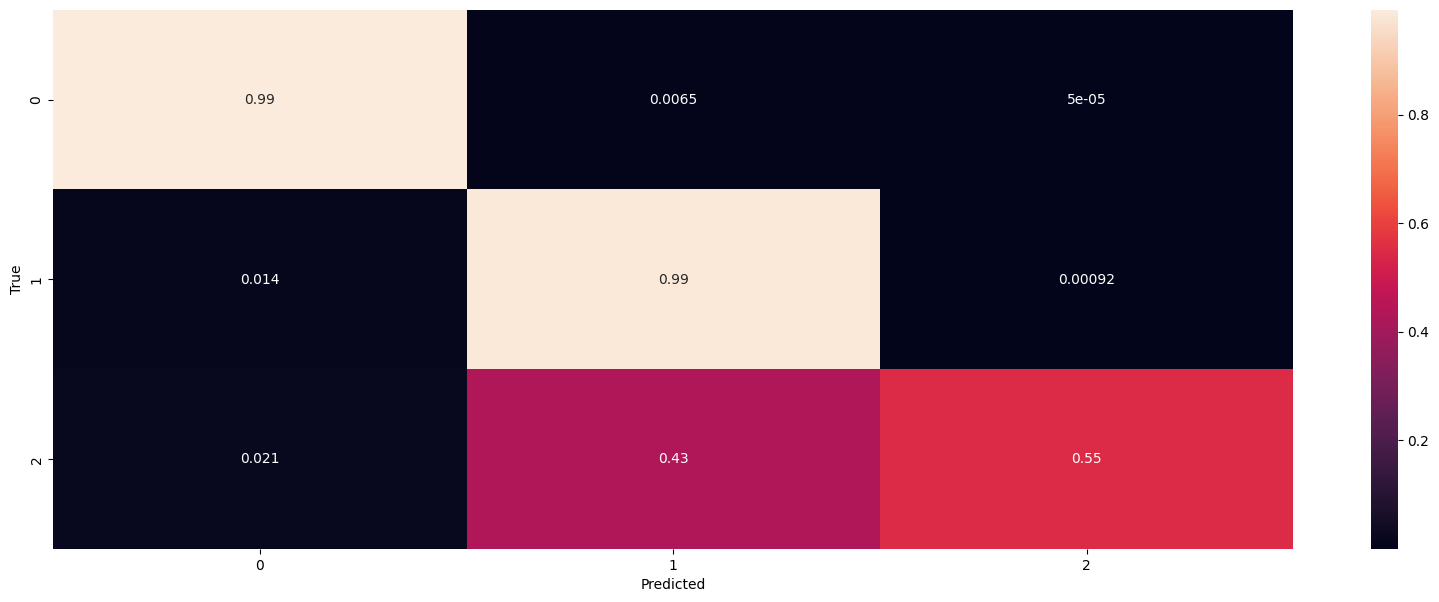

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

### Discriminate betweeen A1/A2, B1/B2, C1/C2

In [20]:
#A
A_train_mask = tf.equal(train_labels_group, 0)
A_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], A_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], A_train_mask)}
A_train_labels =  tf.boolean_mask(train_labels.copy(), A_train_mask)
A_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_train_encodings['input_ids'], "attention_mask_layer": A_train_encodings['attention_mask']}, A_train_labels))
A_dataset = A_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

A_valid_mask = tf.equal(valid_labels_group, 0)
A_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], A_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], A_valid_mask)}
A_valid_labels =  tf.boolean_mask(valid_labels.copy(), A_valid_mask)
A_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_valid_encodings['input_ids'], "attention_mask_layer": A_valid_encodings['attention_mask']}, A_valid_labels))
A_vdataset = A_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

A_test_mask = tf.equal(test_labels_group, 0)
A_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], A_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], A_test_mask)}
A_test_labels =  tf.boolean_mask(test_labels.copy(), A_test_mask)
A_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_test_encodings['input_ids'], "attention_mask_layer": A_test_encodings['attention_mask']}, A_test_labels))
A_tdataset = A_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
A_model = create_roberta_gru_model(model=roberta_model, num_classes=2)

In [22]:
A_model_history = A_model.fit(A_dataset,
                            validation_data=A_vdataset,
                            epochs=1)

5020/5020 [==============================] - 623s 121ms/step - loss: 0.0966 - accuracy: 0.9677 - val_loss: 0.0344 - val_accuracy: 0.9895


In [23]:
#B
B_train_mask = tf.equal(train_labels_group, 1)
B_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], B_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], B_train_mask)}
B_train_labels =  tf.boolean_mask(train_labels.copy(), B_train_mask) - 2
B_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_train_encodings['input_ids'], "attention_mask_layer": B_train_encodings['attention_mask']}, B_train_labels))
B_dataset = B_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

B_valid_mask = tf.equal(valid_labels_group, 1)
B_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], B_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], B_valid_mask)}
B_valid_labels =  tf.boolean_mask(valid_labels.copy(), B_valid_mask) - 2
B_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_valid_encodings['input_ids'], "attention_mask_layer": B_valid_encodings['attention_mask']}, B_valid_labels))
B_vdataset = B_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

B_test_mask = tf.equal(test_labels_group, 1)
B_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], B_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], B_test_mask)}
B_test_labels =  tf.boolean_mask(test_labels.copy(), B_test_mask) - 2
B_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_test_encodings['input_ids'], "attention_mask_layer": B_test_encodings['attention_mask']}, B_test_labels))
B_tdataset = B_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
B_model = create_roberta_gru_model(model=roberta_model, num_classes=2)

In [25]:
B_model_history = B_model.fit(B_dataset,
                              validation_data=B_vdataset,
                              epochs=1)

3531/3531 [==============================] - 430s 118ms/step - loss: 0.2641 - accuracy: 0.8874 - val_loss: 0.1301 - val_accuracy: 0.9519


### Combine

In [34]:
a_pred_mask = tf.equal(preds, 0)
b_pred_mask = tf.equal(preds, 1)

a_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], a_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], a_pred_mask)}
a_preds = A_model.predict([a_test_encodings['input_ids'], a_test_encodings["attention_mask"]])
a_preds = tf.argmax(a_preds, axis=-1)
a_preds = a_preds.numpy() 

b_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], b_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], b_pred_mask)}
b_preds = B_model.predict([b_test_encodings['input_ids'], b_test_encodings["attention_mask"]])
b_preds = tf.argmax(b_preds, axis=-1)
b_preds = b_preds.numpy() + 2



predictions_comb = preds.numpy()
predictions_comb[predictions_comb == 2] = 4
predictions_comb[a_pred_mask] = a_preds
predictions_comb[b_pred_mask] = b_preds

455/455 [==============================] - 45s 99ms/step


In [35]:
cm = tf.math.confusion_matrix(test_labels, predictions_comb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

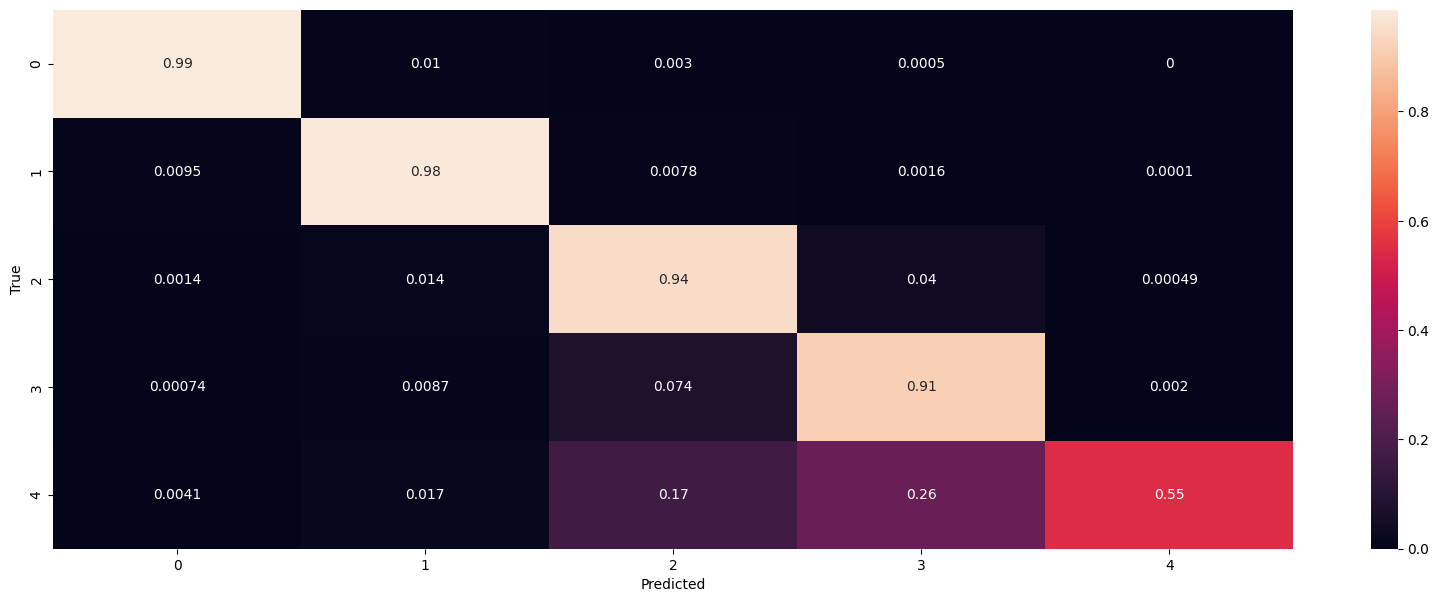

In [36]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [37]:
print(classification_report(test_labels, predictions_comb))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9969
           1       0.97      0.98      0.98      9947
           2       0.94      0.94      0.94     10161
           3       0.84      0.91      0.88      4033
           4       0.97      0.55      0.70       965

    accuracy                           0.95     35075
   macro avg       0.94      0.87      0.90     35075
weighted avg       0.95      0.95      0.95     35075



## 2 Step

### Step 1

In [38]:
s1_train_labels = train_labels.copy()
s1_train_labels[(s1_train_labels == 4)] = 3

s1_valid_labels = valid_labels.copy()
s1_valid_labels[(s1_valid_labels == 4)] = 3

s1_test_labels = test_labels.copy()
s1_test_labels[(s1_test_labels == 4)] = 3

In [39]:
s1_roberta_model = create_roberta_cl_model(model=roberta_model, num_classes=4)

In [40]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, s1_train_labels))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, s1_valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [41]:
s1_roberta_history = s1_roberta_model.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=2)

Epoch 1/2
8803/8803 [==============================] - 1081s 121ms/step - loss: 0.2360 - accuracy: 0.9102 - val_loss: 0.1375 - val_accuracy: 0.9516
Epoch 2/2
8803/8803 [==============================] - 1050s 119ms/step - loss: 0.1325 - accuracy: 0.9531 - val_loss: 0.0890 - val_accuracy: 0.9708


In [42]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, s1_test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [43]:
s1_roberta_model.evaluate(tdataset)

1097/1097 [==============================] - 102s 93ms/step - loss: 0.0918 - accuracy: 0.9693


[0.0918140783905983, 0.9692943692207336]

In [44]:
predictions_s1 = s1_roberta_model.predict([test_encodings['input_ids'], test_encodings["attention_mask"]])
predictions_s1 = tf.argmax(predictions_s1, axis=-1)

1097/1097 [==============================] - 103s 91ms/step


### Step 2

In [45]:
train_mask = tf.equal(s1_train_labels, 3)
s2_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], train_mask)}
s2_train_labels =  tf.boolean_mask(train_labels.copy(), train_mask) -3
s2_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_train_encodings['input_ids'], "attention_mask_layer": s2_train_encodings['attention_mask']}, s2_train_labels))
s2_dataset = s2_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


valid_mask = tf.equal(s1_valid_labels, 3)
s2_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], valid_mask)}
s2_valid_labels = tf.boolean_mask(valid_labels.copy(), valid_mask) - 3
s2_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_valid_encodings['input_ids'], "attention_mask_layer": s2_valid_encodings['attention_mask']}, s2_valid_labels))
s2_vdataset = s2_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

test_mask = tf.equal(s1_test_labels, 3)
s2_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], test_mask)}
s2_test_labels = tf.boolean_mask(test_labels.copy(), test_mask) - 3
s2_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_test_encodings['input_ids'], "attention_mask_layer": s2_test_encodings['attention_mask']}, s2_test_labels))
s2_tdataset = s2_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [46]:
s2_roberta_model = create_roberta_cl_model(model=roberta_model, num_classes=3)

In [47]:
s2_roberta_history = s2_roberta_model.fit(s2_dataset,
                                      validation_data=s2_vdataset,
                                      epochs=1)

1264/1264 [==============================] - 164s 120ms/step - loss: 0.3116 - accuracy: 0.8774 - val_loss: 0.1810 - val_accuracy: 0.9340


In [48]:
predictions_s2 = s2_roberta_model.predict([s2_test_encodings['input_ids'], s2_test_encodings["attention_mask"]])
predictions_s2 = tf.argmax(predictions_s2, axis=-1)

157/157 [==============================] - 17s 91ms/step


### Combine

In [49]:
pred_mask = tf.equal(predictions_s1, 3)
s2_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], pred_mask)}
predictions_s2_2 = s2_roberta_model.predict([s2_test_encodings['input_ids'], s2_test_encodings["attention_mask"]])
predictions_s2_2 = tf.argmax(predictions_s2_2, axis=-1)

predictions_s2_2 = predictions_s2_2.numpy() + 3

predictions_comb = predictions_s1.numpy()
predictions_comb[pred_mask] = predictions_s2_2

146/146 [==============================] - 13s 88ms/step


In [50]:
print(classification_report(test_labels, predictions_comb))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9969
           1       0.99      0.98      0.98      9947
           2       0.93      0.98      0.96     10161
           3       0.91      0.88      0.89      4033
           4       0.84      0.69      0.76       965

    accuracy                           0.96     35075
   macro avg       0.93      0.90      0.92     35075
weighted avg       0.96      0.96      0.96     35075



In [51]:
cm = tf.math.confusion_matrix(test_labels, predictions_comb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

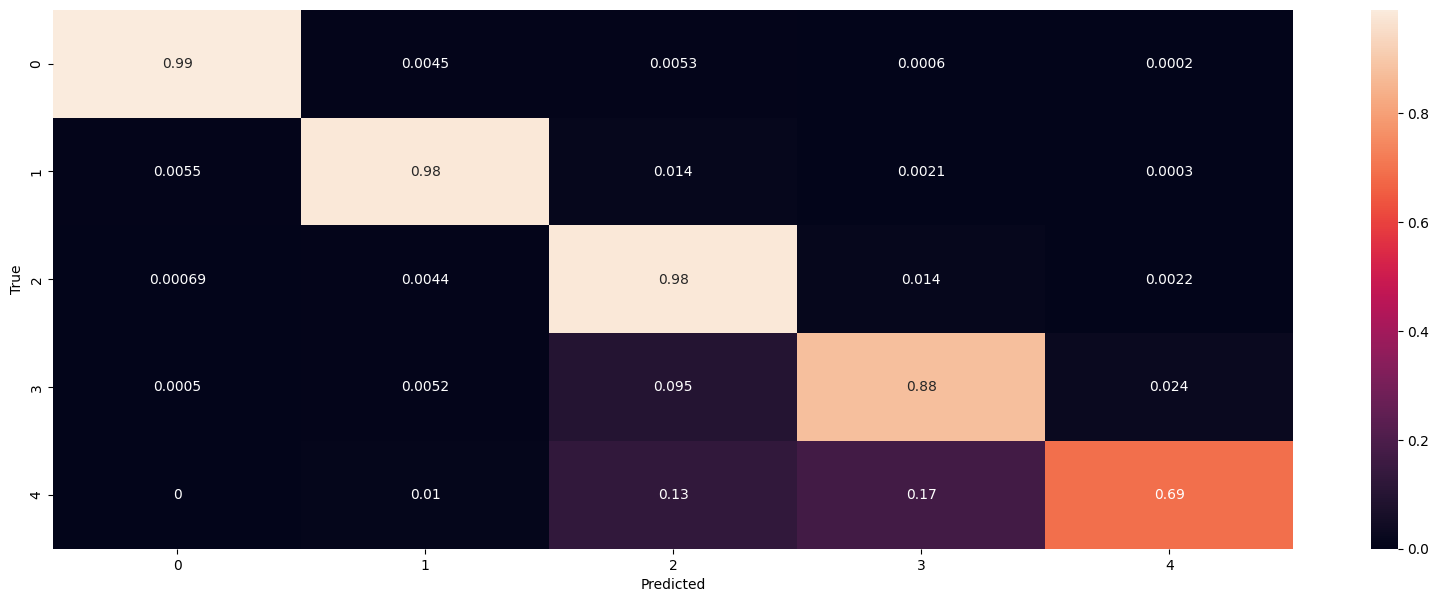

In [52]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")